In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
data=pd.read_csv('/Users/aof_mac/Desktop/banpu/DATA/df_jepx_spotsum.csv')

# Ensure DATETIME is in datetime format and sort the data
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.sort_values('DATETIME', inplace=True)

# We focus only on the SYSTEM_PRICE for the LSTM model
prices = data['SYSTEM_PRICE'].values.reshape(-1, 1)

# Scaling the data - LSTM models are sensitive to the scale of the input data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Function to create sequences of data points for the LSTM model
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
sequence_length = 96  # Corresponding to 48 hours of data at 30 minute intervals

# Create sequences
X, y = create_sequences(scaled_prices, sequence_length)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((260582, 96, 1), (65146, 96, 1), (260582, 1), (65146, 1))

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# Due to resource limitations, we will limit the number of epochs and batch size
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

# Summarize the model's architecture
model.summary()



Epoch 1/5
4072/4072 [==============================] - 369s 90ms/step - loss: 1.1067e-04 - val_loss: 8.6585e-05
Epoch 2/5
4072/4072 [==============================] - 399s 98ms/step - loss: 7.0339e-05 - val_loss: 4.6209e-05
Epoch 3/5
4072/4072 [==============================] - 397s 98ms/step - loss: 6.8444e-05 - val_loss: 5.3577e-05
Epoch 4/5
4072/4072 [==============================] - 395s 97ms/step - loss: 6.4883e-05 - val_loss: 8.7217e-05
Epoch 5/5
4072/4072 [==============================] - 394s 97ms/step - loss: 6.2333e-05 - val_loss: 4.4212e-05
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 96, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 96, 50)            0         
                                                                 
 lstm_3 (LSTM)        

In [7]:
predicted_prices_original = model(X_test)
#y_test_original = scaler.inverse_transform(y_test)


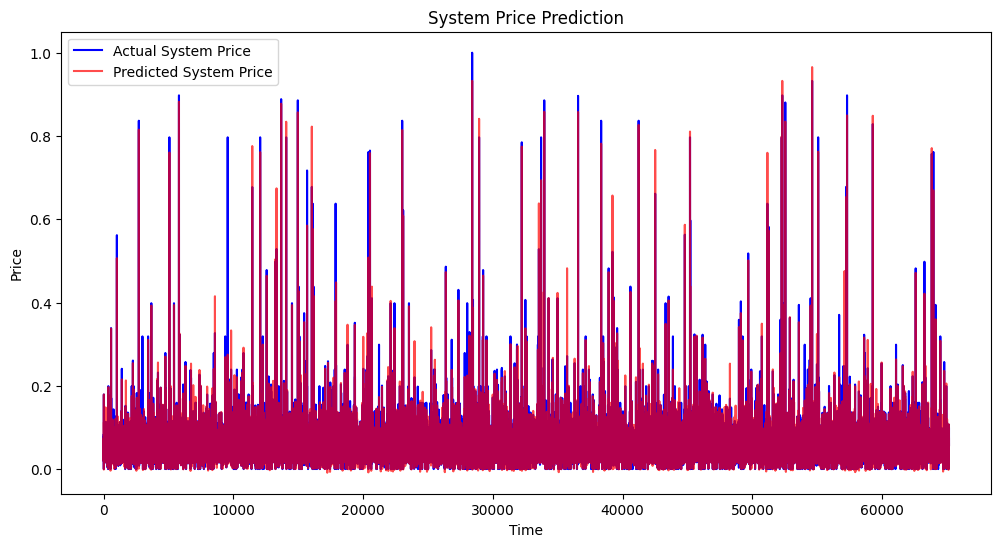

In [8]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test, color='blue', label='Actual System Price')
plt.plot(predicted_prices_original, color='red', alpha=0.7, label='Predicted System Price')
plt.title('System Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
